In [4]:
# # Rule-Based Model para Hidrólise Enzimática

# ## Objetivo
# Este notebook implementa modelos de regressão do Scikit-learn para gerar dados sintéticos baseados em dados experimentais de hidrólise enzimática.

# ### Variáveis de Entrada (Inputs):
# - Celulose (fração)
# - Hemicelulose (fração)
# - Lignina (fração)
# - Solid Loading (g/L)
# - Enzyme Loading (g/L)
# - Time (h)

# ### Variáveis de Saída (Outputs):
# - Glucose Concentration (g/L)
# - Xylose Concentration (g/L)
# - Cellobiose Concentration (g/L)

In [5]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Configuração para melhor visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [6]:
# Carregamento dos dados experimentais
data = pd.read_csv('Experimental Data.csv')

# Exibindo informações básicas dos dados
print("=== INFORMAÇÕES DOS DADOS ===")
print(f"Shape dos dados: {data.shape}")
print(f"\nPrimeiras 5 linhas:")
print(data.head())

print(f"\nInformações sobre os dados:")
print(data.info())

print(f"\nEstatísticas descritivas:")
print(data.describe())

=== INFORMAÇÕES DOS DADOS ===
Shape dos dados: (70, 9)

Primeiras 5 linhas:
   Cellulose   Hemicellulose   Lignin   Solids Loading [g/L]  \
0       0.66           0.083    0.252                  150.0   
1       0.66           0.083    0.252                  150.0   
2       0.66           0.083    0.252                  150.0   
3       0.66           0.083    0.252                  150.0   
4       0.66           0.083    0.252                  150.0   

    Enzyme Loading [g/L]   Time [h]   Glucose Concentration [g/L]  \
0                  0.175        0.0                         0.000   
1                  0.175        1.0                         8.772   
2                  0.175        2.0                        13.363   
3                  0.175        4.0                        23.095   
4                  0.175        6.0                        28.861   

    Xylose Concentration [g/L]   Cellobiose Concentration [g/L]  
0                        0.000                            

In [7]:
# Limpeza dos nomes das colunas (removendo espaços extras)
data.columns = data.columns.str.strip()

# Renomeando colunas para facilitar o uso
column_mapping = {
    'Cellulose': 'Cellulose',
    'Hemicellulose': 'Hemicellulose', 
    'Lignin': 'Lignin',
    'Solids Loading [g/L]': 'Solids_Loading',
    'Enzyme Loading [g/L]': 'Enzyme_Loading',
    'Time [h]': 'Time',
    'Glucose Concentration [g/L]': 'Glucose',
    'Xylose Concentration [g/L]': 'Xylose',
    'Cellobiose Concentration [g/L]': 'Cellobiose'
}

data = data.rename(columns=column_mapping)

print("=== DADOS APÓS LIMPEZA ===")
print(f"Colunas: {list(data.columns)}")
print(f"Valores nulos por coluna:")
print(data.isnull().sum())

# Verificando se há valores negativos ou inconsistentes
print(f"\nVerificação de valores:")
print(f"Valores mínimos por coluna:")
print(data.min())
print(f"\nValores máximos por coluna:")
print(data.max())

=== DADOS APÓS LIMPEZA ===
Colunas: ['Cellulose', 'Hemicellulose', 'Lignin', 'Solids_Loading', 'Enzyme_Loading', 'Time', 'Glucose', 'Xylose', 'Cellobiose']
Valores nulos por coluna:
Cellulose         0
Hemicellulose     0
Lignin            0
Solids_Loading    0
Enzyme_Loading    0
Time              0
Glucose           0
Xylose            0
Cellobiose        0
dtype: int64

Verificação de valores:
Valores mínimos por coluna:
Cellulose           0.660
Hemicellulose       0.083
Lignin              0.252
Solids_Loading    150.000
Enzyme_Loading      0.088
Time                0.000
Glucose             0.000
Xylose              0.000
Cellobiose          0.000
dtype: float64

Valores máximos por coluna:
Cellulose           0.660
Hemicellulose       0.083
Lignin              0.252
Solids_Loading    200.000
Enzyme_Loading      1.050
Time               96.000
Glucose            84.520
Xylose             11.988
Cellobiose          2.192
dtype: float64


In [8]:
# Definindo variáveis de entrada (features) e saída (targets)
input_features = ['Cellulose', 'Hemicellulose', 'Lignin', 'Solids_Loading', 'Enzyme_Loading', 'Time']
output_targets = ['Glucose', 'Xylose', 'Cellobiose']

# Separando X (inputs) e y (outputs)
X = data[input_features].copy()
y = data[output_targets].copy()

print("=== VARIÁVEIS DE ENTRADA (X) ===")
print(X.head())
print(f"\nShape de X: {X.shape}")

print("\n=== VARIÁVEIS DE SAÍDA (y) ===")
print(y.head())
print(f"\nShape de y: {y.shape}")

# Verificando correlações entre as variáveis
print("\n=== MATRIZ DE CORRELAÇÃO ===")
correlation_matrix = data[input_features + output_targets].corr()
print(correlation_matrix)

=== VARIÁVEIS DE ENTRADA (X) ===
   Cellulose  Hemicellulose  Lignin  Solids_Loading  Enzyme_Loading  Time
0       0.66          0.083   0.252           150.0           0.175   0.0
1       0.66          0.083   0.252           150.0           0.175   1.0
2       0.66          0.083   0.252           150.0           0.175   2.0
3       0.66          0.083   0.252           150.0           0.175   4.0
4       0.66          0.083   0.252           150.0           0.175   6.0

Shape de X: (70, 6)

=== VARIÁVEIS DE SAÍDA (y) ===
   Glucose  Xylose  Cellobiose
0    0.000   0.000       0.000
1    8.772   1.435       0.175
2   13.363   2.007       0.367
3   23.095   2.829       0.691
4   28.861   3.201       0.823

Shape de y: (70, 3)

=== MATRIZ DE CORRELAÇÃO ===
                Cellulose  Hemicellulose  Lignin  Solids_Loading  \
Cellulose             NaN            NaN     NaN             NaN   
Hemicellulose         NaN            NaN     NaN             NaN   
Lignin                NaN    

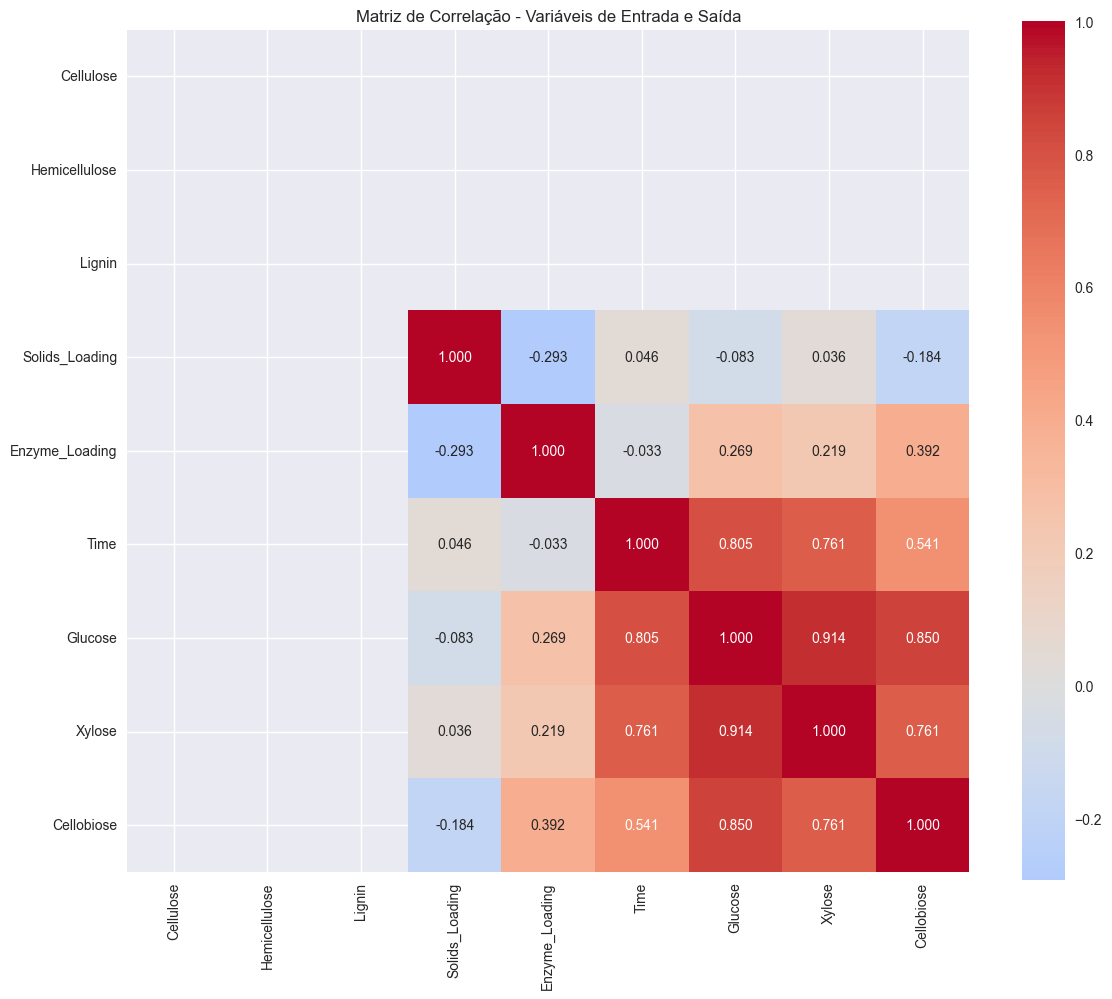

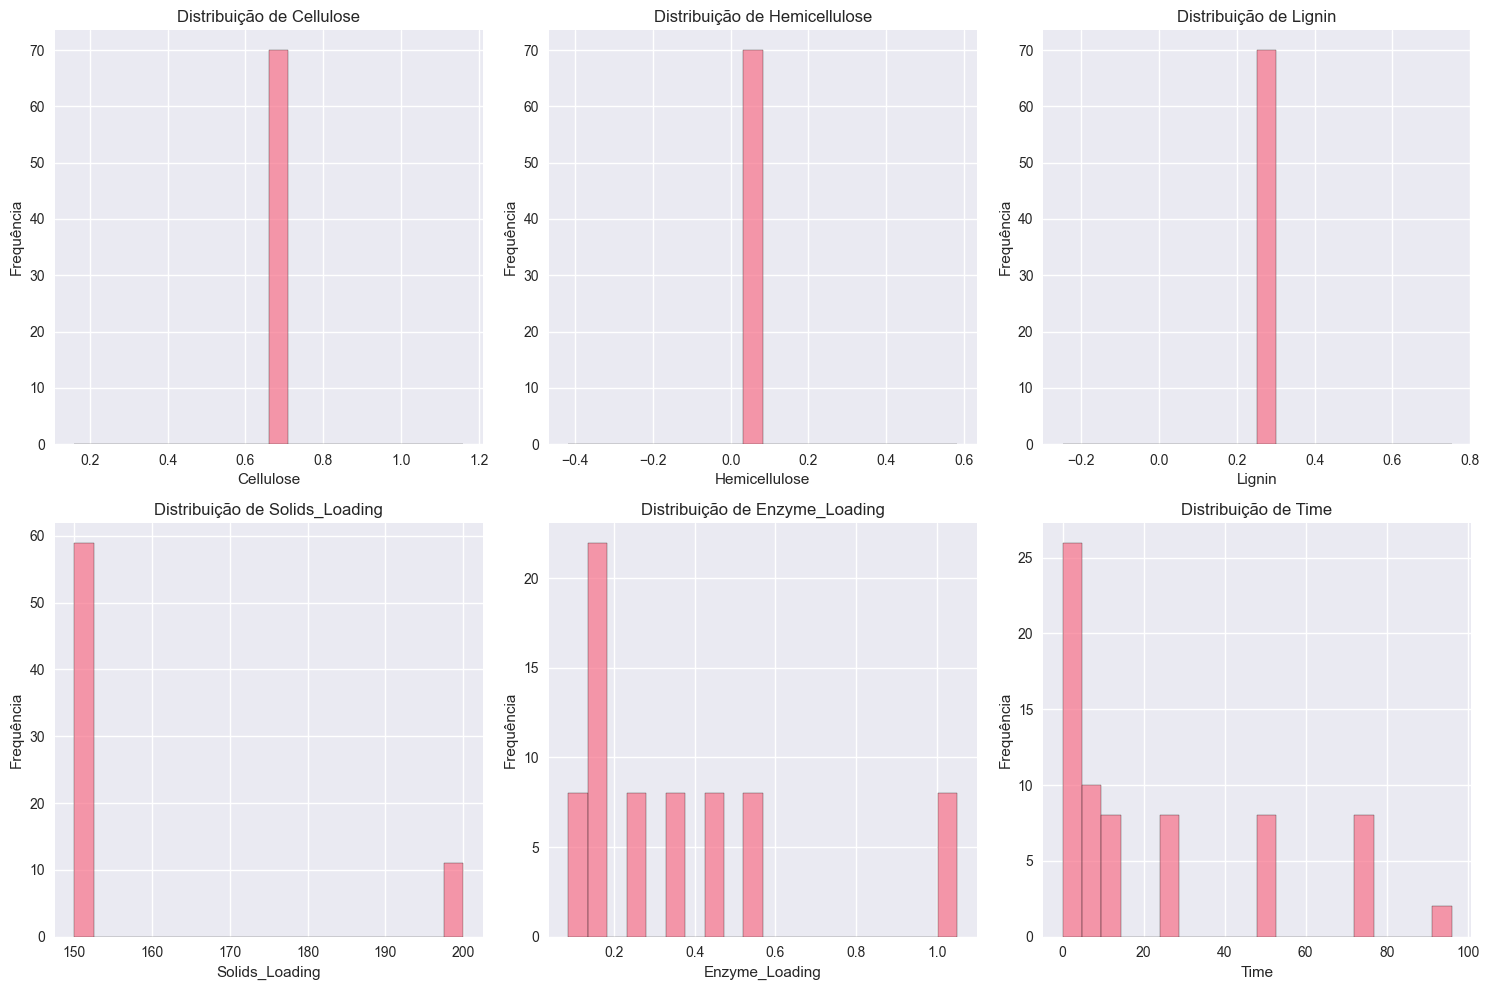

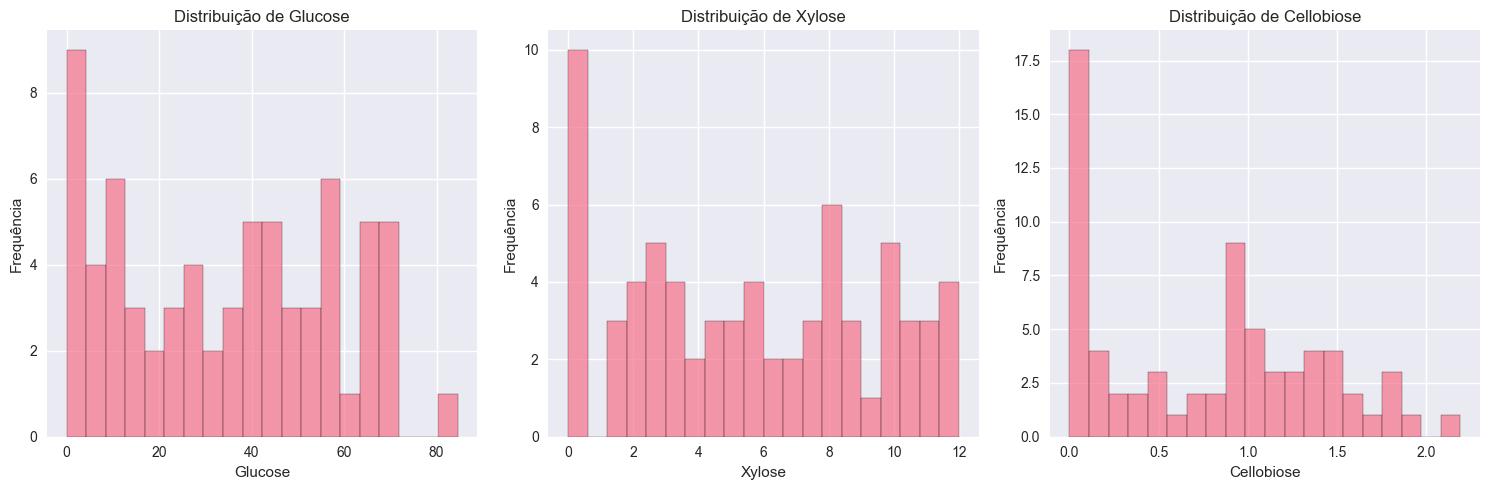

In [9]:
# Visualização da matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Matriz de Correlação - Variáveis de Entrada e Saída')
plt.tight_layout()
plt.show()

# Distribuição das variáveis de entrada
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(input_features):
    axes[i].hist(X[feature], bins=20, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribuição de {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

# Distribuição das variáveis de saída
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, target in enumerate(output_targets):
    axes[i].hist(y[target], bins=20, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribuição de {target}')
    axes[i].set_xlabel(target)
    axes[i].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

In [10]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print("=== DIVISÃO DOS DADOS ===")
print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")
print(f"Proporção treino/teste: {len(X_train)/len(X_test):.2f}")

# Padronização das variáveis
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print(f"\nDados padronizados:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")

# Convertendo de volta para DataFrame para facilitar o uso
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=input_features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=input_features)
y_train_scaled_df = pd.DataFrame(y_train_scaled, columns=output_targets)
y_test_scaled_df = pd.DataFrame(y_test_scaled, columns=output_targets)

=== DIVISÃO DOS DADOS ===
Tamanho do conjunto de treino: (56, 6)
Tamanho do conjunto de teste: (14, 6)
Proporção treino/teste: 4.00

Dados padronizados:
X_train_scaled shape: (56, 6)
y_train_scaled shape: (56, 3)


In [11]:
# Definindo diferentes modelos de regressão para comparação
models = {
    'Linear Regression': MultiOutputRegressor(LinearRegression()),
    'Ridge Regression': MultiOutputRegressor(Ridge(alpha=1.0, random_state=42)),
    'Lasso Regression': MultiOutputRegressor(Lasso(alpha=0.1, random_state=42)),
    'Elastic Net': MultiOutputRegressor(ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)),
    'Random Forest': MultiOutputRegressor(RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-1
    )),
    'Gradient Boosting': MultiOutputRegressor(GradientBoostingRegressor(
        n_estimators=100, random_state=42
    )),
    'Support Vector Regression': MultiOutputRegressor(SVR(
        kernel='rbf', C=100, gamma='scale'
    )),
    'K-Nearest Neighbors': MultiOutputRegressor(KNeighborsRegressor(
        n_neighbors=5, weights='distance'
    )),
    'Decision Tree': MultiOutputRegressor(DecisionTreeRegressor(
        random_state=42, max_depth=10
    ))
}

print("=== MODELOS DEFINIDOS ===")
for name in models.keys():
    print(f"- {name}")

=== MODELOS DEFINIDOS ===
- Linear Regression
- Ridge Regression
- Lasso Regression
- Elastic Net
- Random Forest
- Gradient Boosting
- Support Vector Regression
- K-Nearest Neighbors
- Decision Tree


In [12]:
# Função para avaliar modelos
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Avalia um modelo de regressão e retorna métricas de performance
    """
    # Treinamento
    model.fit(X_train, y_train)
    
    # Predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métricas para treino
    train_mse = mean_squared_error(y_train, y_train_pred, multioutput='raw_values')
    train_r2 = r2_score(y_train, y_train_pred, multioutput='raw_values')
    train_mae = mean_absolute_error(y_train, y_train_pred, multioutput='raw_values')
    
    # Métricas para teste
    test_mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
    test_r2 = r2_score(y_test, y_test_pred, multioutput='raw_values')
    test_mae = mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
    
    return {
        'model_name': model_name,
        'train_mse': train_mse,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'test_mse': test_mse,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }

print("Função de avaliação definida com sucesso!")

Função de avaliação definida com sucesso!


In [13]:
# Treinamento e avaliação de todos os modelos
print("=== TREINAMENTO E AVALIAÇÃO DOS MODELOS ===")
results = []

for name, model in models.items():
    print(f"\nTreinando {name}...")
    
    # Avaliação com dados padronizados
    result = evaluate_model(
        model, X_train_scaled, X_test_scaled, 
        y_train_scaled, y_test_scaled, name
    )
    results.append(result)
    
    # Exibindo resultados básicos
    print(f"R² médio (teste): {np.mean(result['test_r2']):.4f}")
    print(f"MSE médio (teste): {np.mean(result['test_mse']):.4f}")

print("\nTodos os modelos foram treinados com sucesso!")

=== TREINAMENTO E AVALIAÇÃO DOS MODELOS ===

Treinando Linear Regression...
R² médio (teste): 0.2549
MSE médio (teste): 0.5144

Treinando Ridge Regression...
R² médio (teste): 0.2673
MSE médio (teste): 0.5058

Treinando Lasso Regression...
R² médio (teste): 0.3351
MSE médio (teste): 0.4634

Treinando Elastic Net...
R² médio (teste): 0.3251
MSE médio (teste): 0.4686

Treinando Random Forest...
R² médio (teste): 0.7981
MSE médio (teste): 0.1337

Treinando Gradient Boosting...
R² médio (teste): 0.6829
MSE médio (teste): 0.1849

Treinando Support Vector Regression...
R² médio (teste): -0.8924
MSE médio (teste): 1.0477

Treinando K-Nearest Neighbors...
R² médio (teste): 0.5647
MSE médio (teste): 0.2955

Treinando Decision Tree...
R² médio (teste): 0.5772
MSE médio (teste): 0.2631

Todos os modelos foram treinados com sucesso!


In [14]:
# Comparação detalhada dos resultados
print("=== COMPARAÇÃO DETALHADA DOS MODELOS ===")

# Criando DataFrame para comparação
comparison_data = []
target_names = output_targets

for result in results:
    for i, target in enumerate(target_names):
        comparison_data.append({
            'Model': result['model_name'],
            'Target': target,
            'Train_R2': result['train_r2'][i],
            'Test_R2': result['test_r2'][i],
            'Train_MSE': result['train_mse'][i],
            'Test_MSE': result['test_mse'][i],
            'Train_MAE': result['train_mae'][i],
            'Test_MAE': result['test_mae'][i]
        })

comparison_df = pd.DataFrame(comparison_data)

# Resumo por modelo (média entre targets)
model_summary = comparison_df.groupby('Model').agg({
    'Test_R2': 'mean',
    'Test_MSE': 'mean',
    'Test_MAE': 'mean'
}).sort_values('Test_R2', ascending=False)

print("Resumo por modelo (média entre targets):")
print(model_summary)

# Melhor modelo para cada target
print("\n=== MELHOR MODELO PARA CADA TARGET ===")
for target in target_names:
    target_data = comparison_df[comparison_df['Target'] == target]
    best_model = target_data.loc[target_data['Test_R2'].idxmax()]
    print(f"\n{target}:")
    print(f"  Melhor modelo: {best_model['Model']}")
    print(f"  R² teste: {best_model['Test_R2']:.4f}")
    print(f"  MSE teste: {best_model['Test_MSE']:.4f}")
    print(f"  MAE teste: {best_model['Test_MAE']:.4f}")

=== COMPARAÇÃO DETALHADA DOS MODELOS ===
Resumo por modelo (média entre targets):
                            Test_R2  Test_MSE  Test_MAE
Model                                                  
Random Forest              0.798085  0.133738  0.277967
Gradient Boosting          0.682901  0.184893  0.260829
Decision Tree              0.577210  0.263135  0.336010
K-Nearest Neighbors        0.564724  0.295514  0.444501
Lasso Regression           0.335089  0.463440  0.601879
Elastic Net                0.325061  0.468588  0.601855
Ridge Regression           0.267268  0.505830  0.615617
Linear Regression          0.254896  0.514367  0.618871
Support Vector Regression -0.892446  1.047699  0.507825

=== MELHOR MODELO PARA CADA TARGET ===

Glucose:
  Melhor modelo: Random Forest
  R² teste: 0.8501
  MSE teste: 0.1104
  MAE teste: 0.2487

Xylose:
  Melhor modelo: Gradient Boosting
  R² teste: 0.9364
  MSE teste: 0.0537
  MAE teste: 0.1877

Cellobiose:
  Melhor modelo: Random Forest
  R² teste: 0.7

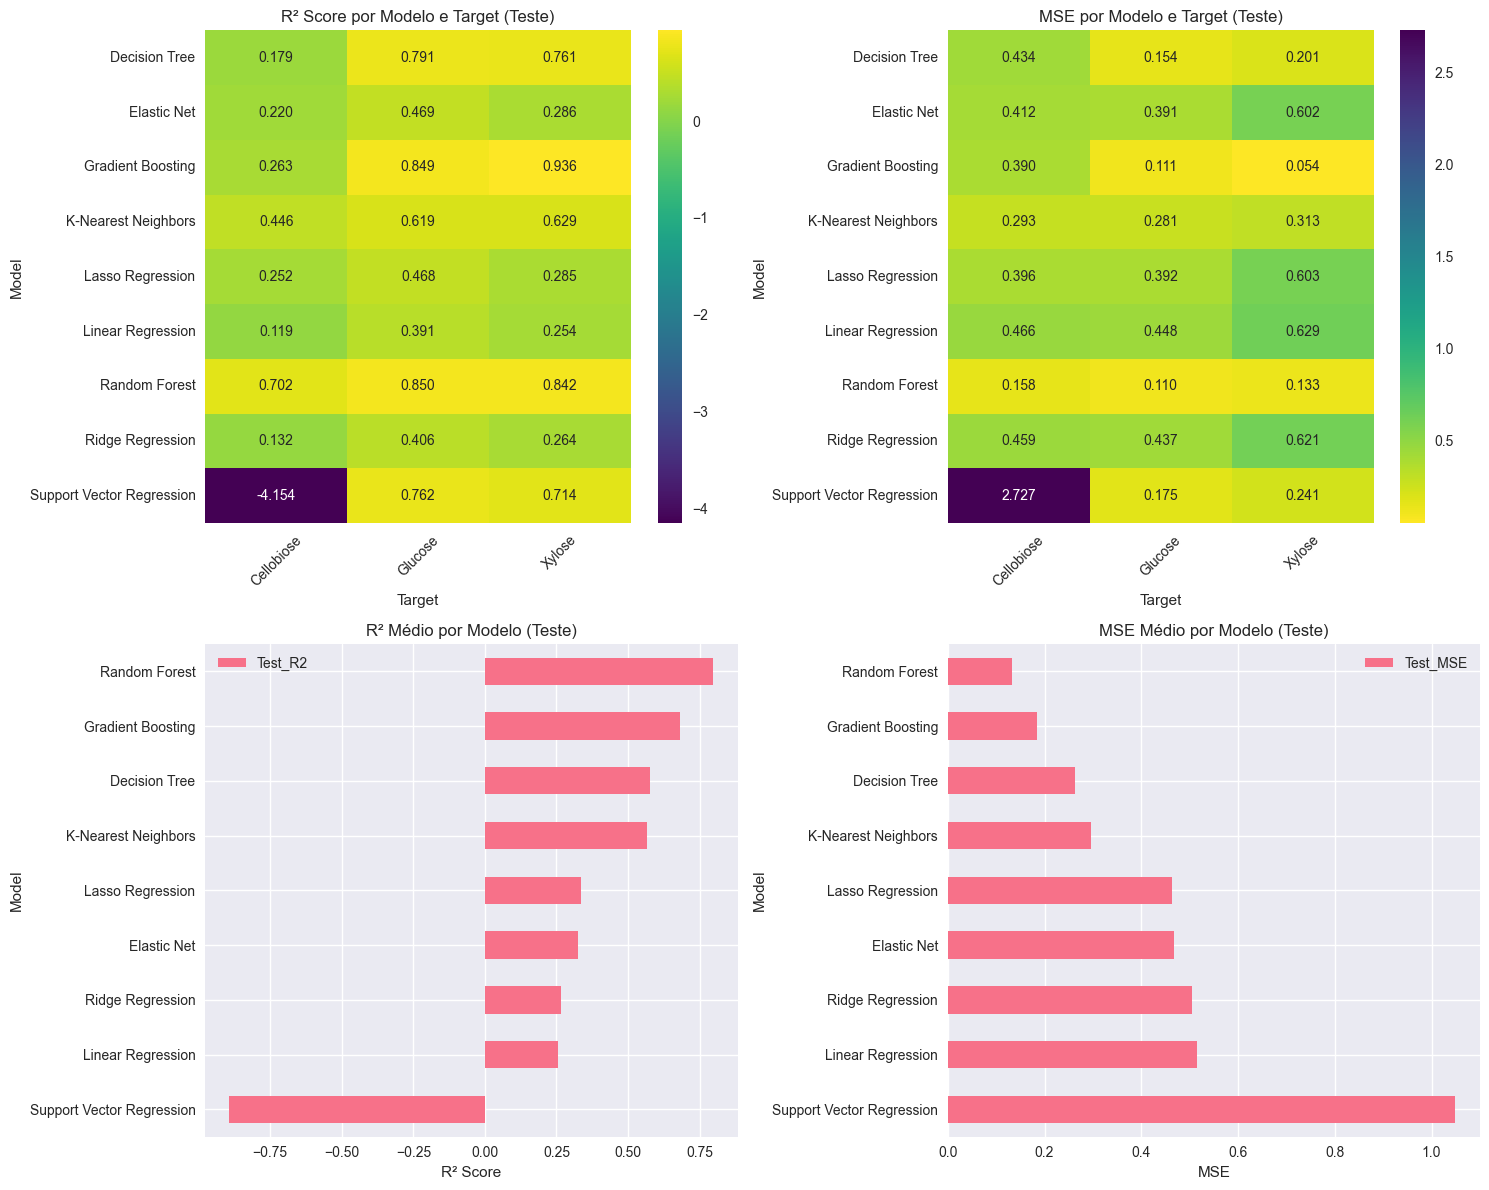


=== MELHOR MODELO GERAL ===
Modelo: Random Forest
R² médio: 0.7981
MSE médio: 0.1337
MAE médio: 0.2780


In [15]:
# Visualização da performance dos modelos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² por modelo e target
pivot_r2 = comparison_df.pivot(index='Model', columns='Target', values='Test_R2')
sns.heatmap(pivot_r2, annot=True, cmap='viridis', ax=axes[0,0], fmt='.3f')
axes[0,0].set_title('R² Score por Modelo e Target (Teste)')
axes[0,0].tick_params(axis='x', rotation=45)

# MSE por modelo e target
pivot_mse = comparison_df.pivot(index='Model', columns='Target', values='Test_MSE')
sns.heatmap(pivot_mse, annot=True, cmap='viridis_r', ax=axes[0,1], fmt='.3f')
axes[0,1].set_title('MSE por Modelo e Target (Teste)')
axes[0,1].tick_params(axis='x', rotation=45)

# Comparação geral de R²
model_summary.sort_values('Test_R2').plot(kind='barh', y='Test_R2', ax=axes[1,0])
axes[1,0].set_title('R² Médio por Modelo (Teste)')
axes[1,0].set_xlabel('R² Score')

# Comparação geral de MSE
model_summary.sort_values('Test_MSE', ascending=False).plot(kind='barh', y='Test_MSE', ax=axes[1,1])
axes[1,1].set_title('MSE Médio por Modelo (Teste)')
axes[1,1].set_xlabel('MSE')

plt.tight_layout()
plt.show()

# Identificando o melhor modelo geral
best_model_name = model_summary.index[0]
print(f"\n=== MELHOR MODELO GERAL ===")
print(f"Modelo: {best_model_name}")
print(f"R² médio: {model_summary.loc[best_model_name, 'Test_R2']:.4f}")
print(f"MSE médio: {model_summary.loc[best_model_name, 'Test_MSE']:.4f}")
print(f"MAE médio: {model_summary.loc[best_model_name, 'Test_MAE']:.4f}")

In [16]:
# Otimização do melhor modelo usando GridSearchCV
print("=== OTIMIZAÇÃO DO MELHOR MODELO ===")

# Selecionando o melhor modelo para otimização
best_model_type = models[best_model_name]

# Definindo parâmetros para grid search baseado no tipo do modelo
if 'Random Forest' in best_model_name:
    param_grid = {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__max_depth': [5, 10, 15, None],
        'estimator__min_samples_split': [2, 5, 10],
        'estimator__min_samples_leaf': [1, 2, 4]
    }
elif 'Gradient Boosting' in best_model_name:
    param_grid = {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__max_depth': [3, 5, 7],
        'estimator__learning_rate': [0.01, 0.1, 0.2],
        'estimator__subsample': [0.8, 0.9, 1.0]
    }
elif 'SVR' in best_model_name:
    param_grid = {
        'estimator__C': [0.1, 1, 10, 100],
        'estimator__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'estimator__kernel': ['rbf', 'linear', 'poly']
    }
elif 'Ridge' in best_model_name:
    param_grid = {
        'estimator__alpha': [0.1, 1.0, 10.0, 100.0]
    }
elif 'Lasso' in best_model_name:
    param_grid = {
        'estimator__alpha': [0.01, 0.1, 1.0, 10.0]
    }
elif 'Elastic Net' in best_model_name:
    param_grid = {
        'estimator__alpha': [0.01, 0.1, 1.0],
        'estimator__l1_ratio': [0.1, 0.5, 0.9]
    }
else:
    # Para modelos mais simples, fazemos uma busca básica
    param_grid = {}

print(f"Otimizando {best_model_name}...")
print(f"Parâmetros a serem testados: {len(param_grid) if param_grid else 0}")

if param_grid:
    # Grid Search
    grid_search = GridSearchCV(
        best_model_type, param_grid, 
        cv=5, scoring='r2', n_jobs=-1, verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train_scaled)
    
    print(f"Melhores parâmetros: {grid_search.best_params_}")
    print(f"Melhor score CV: {grid_search.best_score_:.4f}")
    
    # Modelo otimizado
    optimized_model = grid_search.best_estimator_
else:
    print("Usando modelo padrão (sem otimização de hiperparâmetros)")
    optimized_model = best_model_type
    optimized_model.fit(X_train_scaled, y_train_scaled)

=== OTIMIZAÇÃO DO MELHOR MODELO ===
Otimizando Random Forest...
Parâmetros a serem testados: 4
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Melhores parâmetros: {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 50}
Melhor score CV: 0.7735


In [17]:
# Geração de dados sintéticos usando o modelo otimizado
print("=== GERAÇÃO DE DADOS SINTÉTICOS ===")

def generate_synthetic_data(n_samples=1000, add_noise=True, noise_level=0.05):
    """
    Gera dados sintéticos baseados no modelo treinado
    """
    np.random.seed(42)
    
    # Definindo faixas baseadas nos dados originais
    ranges = {
        'Cellulose': (0.60, 0.70),
        'Hemicellulose': (0.07, 0.09),
        'Lignin': (0.20, 0.30),
        'Solids_Loading': (100, 250),
        'Enzyme_Loading': (0.05, 1.2),
        'Time': (0, 100)
    }
    
    # Gerando inputs sintéticos
    synthetic_inputs = {}
    for feature, (min_val, max_val) in ranges.items():
        if feature == 'Time':
            # Distribuição mais realística para tempo (mais pontos no início)
            synthetic_inputs[feature] = np.random.exponential(scale=20, size=n_samples)
            synthetic_inputs[feature] = np.clip(synthetic_inputs[feature], min_val, max_val)
        else:
            synthetic_inputs[feature] = np.random.uniform(min_val, max_val, n_samples)
    
    synthetic_X = pd.DataFrame(synthetic_inputs)
    
    # Padronizando os inputs sintéticos
    synthetic_X_scaled = scaler_X.transform(synthetic_X)
    
    # Gerando predições
    synthetic_y_scaled = optimized_model.predict(synthetic_X_scaled)
    
    # Desnormalizando as predições
    synthetic_y = scaler_y.inverse_transform(synthetic_y_scaled)
    synthetic_y_df = pd.DataFrame(synthetic_y, columns=output_targets)
    
    # Adicionando ruído realístico se solicitado
    if add_noise:
        for target in output_targets:
            noise = np.random.normal(0, noise_level * synthetic_y_df[target].std(), n_samples)
            synthetic_y_df[target] += noise
            # Garantindo que concentrações não sejam negativas
            synthetic_y_df[target] = np.maximum(synthetic_y_df[target], 0)
    
    # Combinando inputs e outputs
    synthetic_data = pd.concat([synthetic_X, synthetic_y_df], axis=1)
    
    return synthetic_data

# Gerando conjuntos sintéticos
print("Gerando dados sintéticos...")

# Conjunto principal (1000 amostras)
synthetic_main = generate_synthetic_data(n_samples=1000, add_noise=True)

# Conjunto de validação (500 amostras com menos ruído)
synthetic_validation = generate_synthetic_data(n_samples=500, add_noise=True, noise_level=0.02)

# Conjunto limpo (200 amostras sem ruído)
synthetic_clean = generate_synthetic_data(n_samples=200, add_noise=False)

print(f"Dados sintéticos gerados:")
print(f"- Conjunto principal: {synthetic_main.shape}")
print(f"- Conjunto validação: {synthetic_validation.shape}")
print(f"- Conjunto limpo: {synthetic_clean.shape}")

# Exibindo estatísticas dos dados sintéticos
print(f"\n=== ESTATÍSTICAS DOS DADOS SINTÉTICOS ===")
print("Conjunto principal:")
print(synthetic_main.describe())

=== GERAÇÃO DE DADOS SINTÉTICOS ===
Gerando dados sintéticos...
Dados sintéticos gerados:
- Conjunto principal: (1000, 9)
- Conjunto validação: (500, 9)
- Conjunto limpo: (200, 9)

=== ESTATÍSTICAS DOS DADOS SINTÉTICOS ===
Conjunto principal:
         Cellulose  Hemicellulose       Lignin  Solids_Loading  \
count  1000.000000    1000.000000  1000.000000     1000.000000   
mean      0.649026       0.080140     0.250241      173.556257   
std       0.029214       0.005844     0.029067       42.973402   
min       0.600463       0.070064     0.200001      100.098009   
25%       0.623597       0.074821     0.226135      136.285116   
50%       0.649681       0.080375     0.250061      172.641893   
75%       0.674432       0.085209     0.275910      210.631122   
max       0.699972       0.089988     0.299782      249.933655   

       Enzyme_Loading         Time      Glucose       Xylose   Cellobiose  
count     1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  
mean      

=== COMPARAÇÃO: DADOS REAIS vs SINTÉTICOS ===


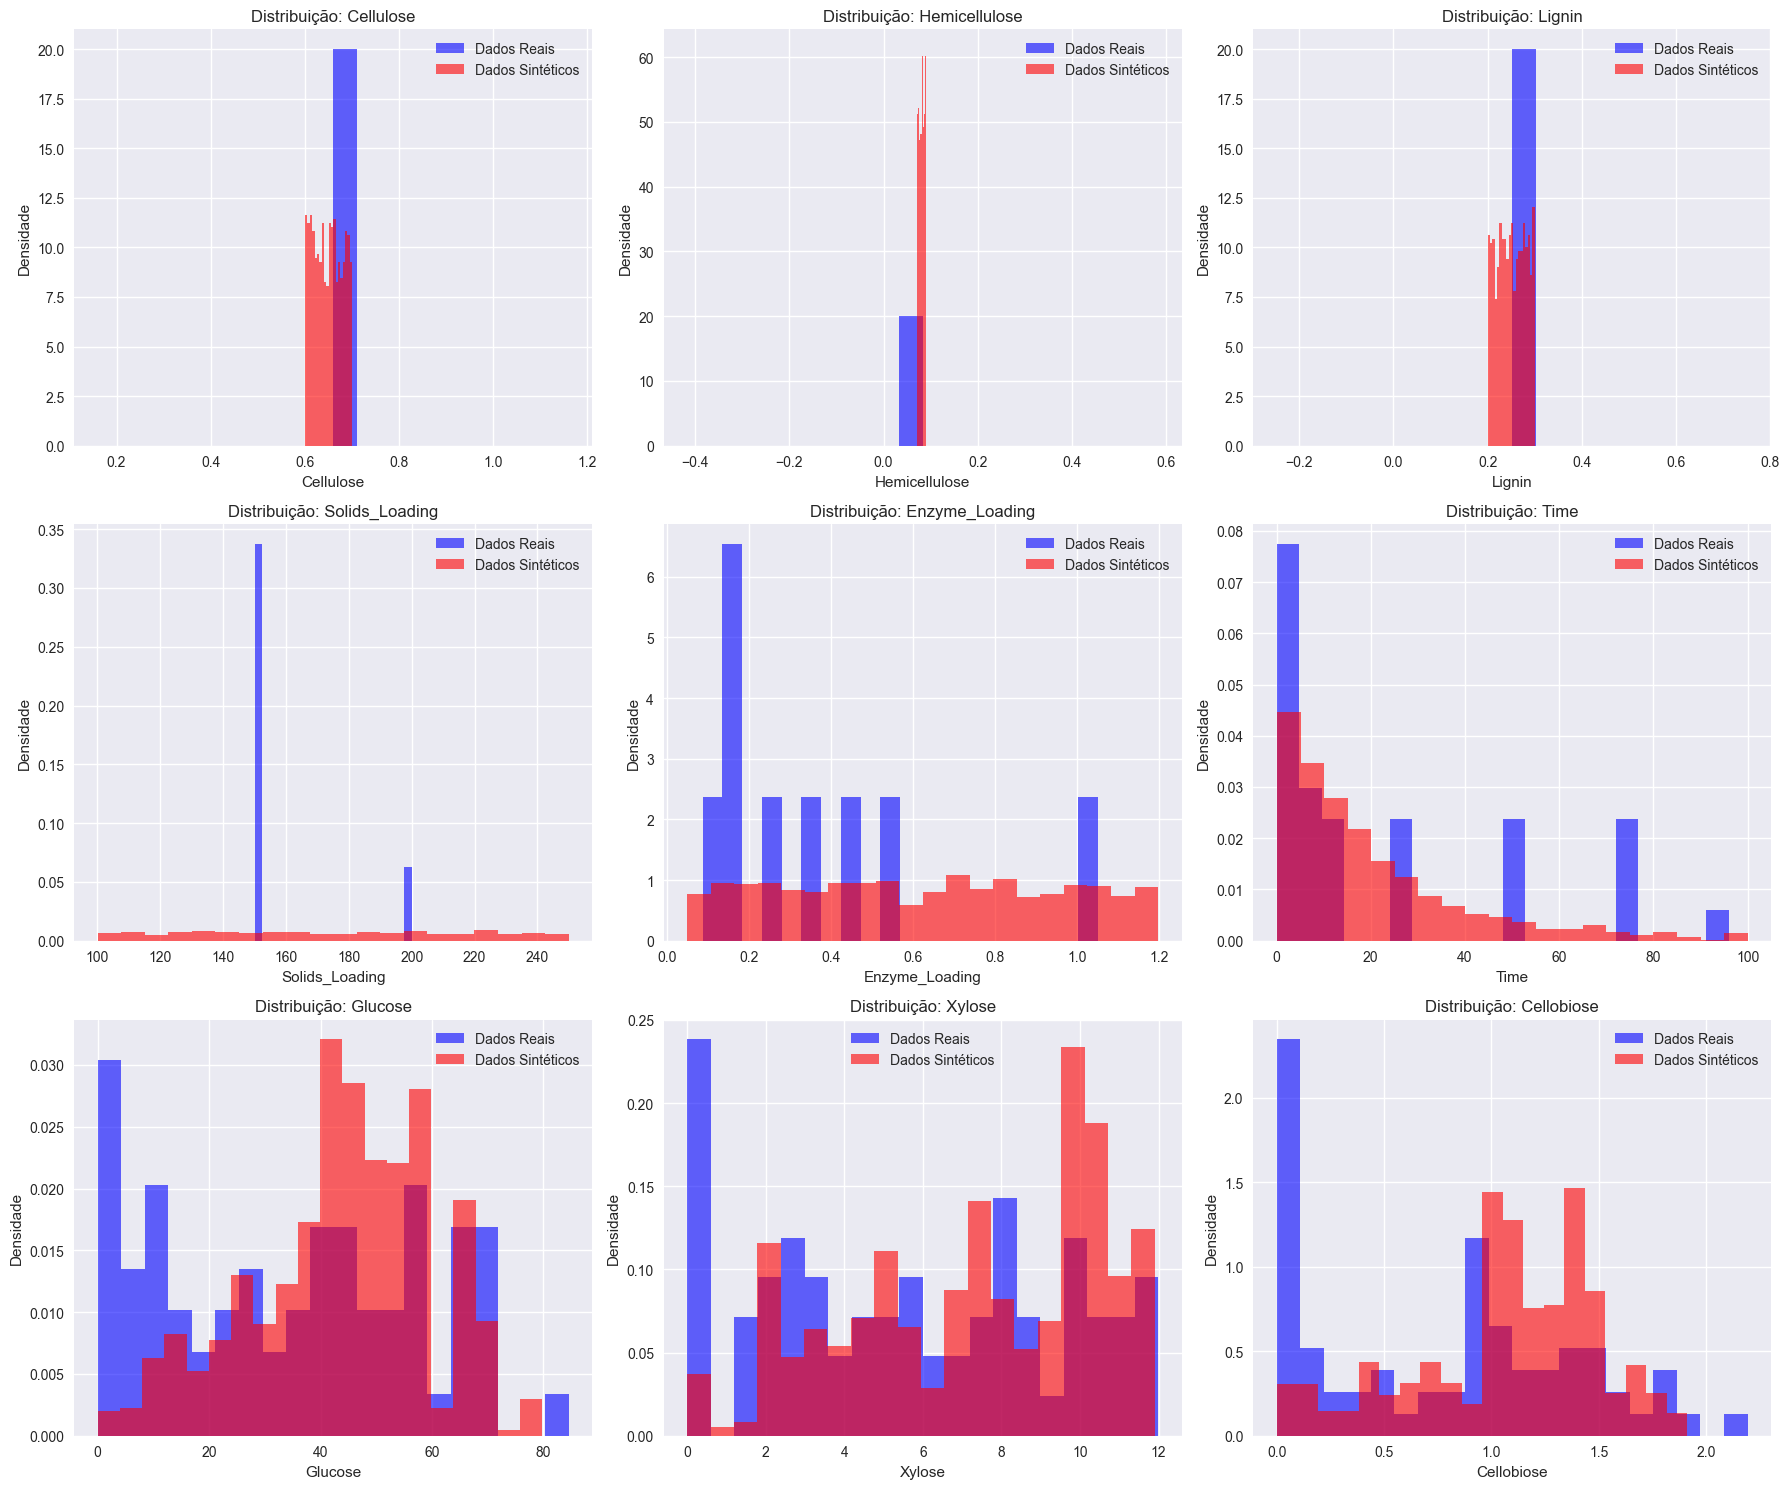


=== COMPARAÇÃO ESTATÍSTICA ===
                 Real_Mean  Synthetic_Mean      Real_Std  Synthetic_Std  \
Cellulose         0.660000        0.649026  3.354718e-16       0.029214   
Hemicellulose     0.083000        0.080140  1.397799e-17       0.005844   
Lignin            0.252000        0.250241  1.118239e-16       0.029067   
Solids_Loading  157.857143      173.556257  1.832816e+01      42.973402   
Enzyme_Loading    0.365171        0.618221  2.821834e-01       0.329831   
Time             21.942857       19.985887  2.715489e+01      19.742228   
Glucose          34.448586       43.950174  2.364019e+01      16.053114   
Xylose            5.623629        7.369806  3.781434e+00       3.169357   
Cellobiose        0.768386        1.074622  6.284979e-01       0.429351   

                Mean_Diff   Std_Diff  
Cellulose        0.010974   0.029214  
Hemicellulose    0.002860   0.005844  
Lignin           0.001759   0.029067  
Solids_Loading  15.699114  24.645245  
Enzyme_Loading   0.253

In [18]:
# Comparação entre dados reais e sintéticos
print("=== COMPARAÇÃO: DADOS REAIS vs SINTÉTICOS ===")

# Visualização comparativa das distribuições
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

all_features = input_features + output_targets

for i, feature in enumerate(all_features):
    axes[i].hist(data[feature], bins=20, alpha=0.6, label='Dados Reais', color='blue', density=True)
    axes[i].hist(synthetic_main[feature], bins=20, alpha=0.6, label='Dados Sintéticos', color='red', density=True)
    axes[i].set_title(f'Distribuição: {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Densidade')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Comparação estatística
print("\n=== COMPARAÇÃO ESTATÍSTICA ===")
comparison_stats = pd.DataFrame({
    'Real_Mean': data[all_features].mean(),
    'Synthetic_Mean': synthetic_main[all_features].mean(),
    'Real_Std': data[all_features].std(),
    'Synthetic_Std': synthetic_main[all_features].std(),
})

comparison_stats['Mean_Diff'] = abs(comparison_stats['Real_Mean'] - comparison_stats['Synthetic_Mean'])
comparison_stats['Std_Diff'] = abs(comparison_stats['Real_Std'] - comparison_stats['Synthetic_Std'])

print(comparison_stats)

# Correlações entre dados reais e sintéticos
print(f"\n=== CORRELAÇÕES ===")
print("Dados Reais:")
print(data[output_targets].corr())
print("\nDados Sintéticos:")
print(synthetic_main[output_targets].corr())

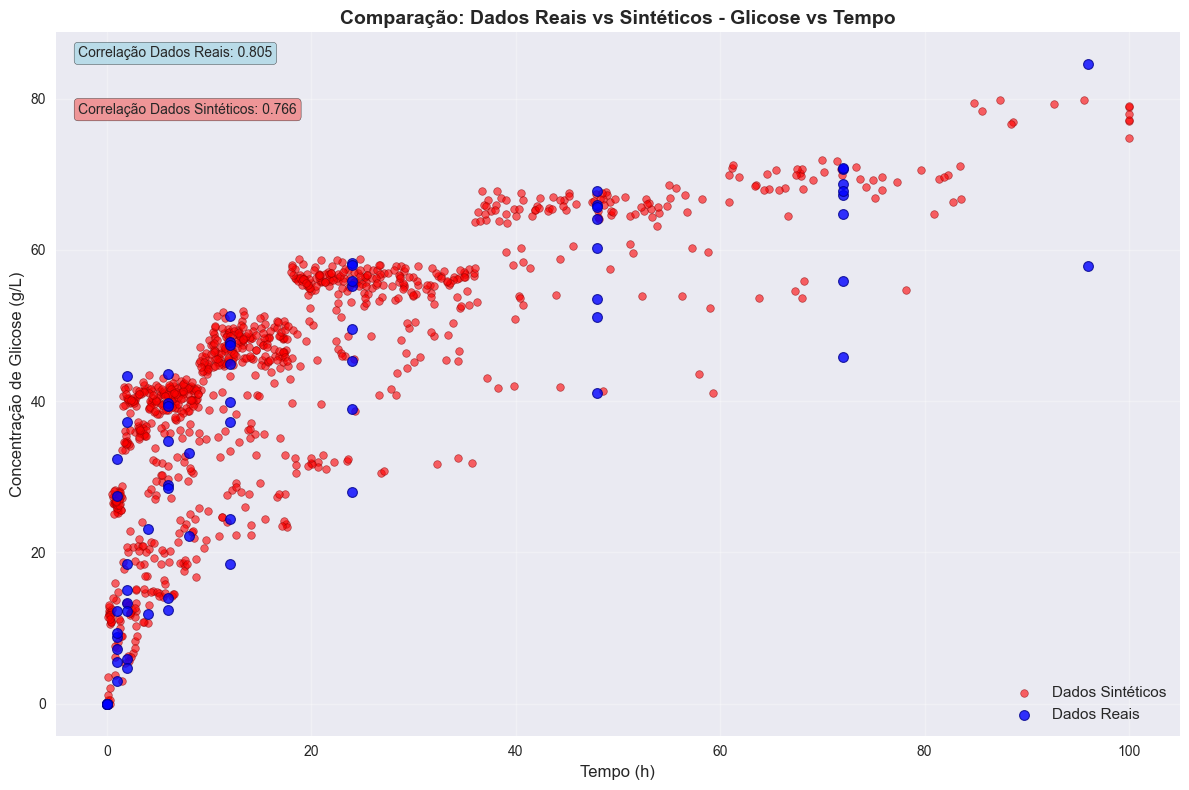

=== ESTATÍSTICAS: GLICOSE vs TEMPO ===
Dados Reais - Glicose:
  Mínimo: 0.00 g/L
  Máximo: 84.52 g/L
  Média: 34.45 g/L
  Correlação com Tempo: 0.8045

Dados Sintéticos - Glicose:
  Mínimo: 0.00 g/L
  Máximo: 79.81 g/L
  Média: 43.95 g/L
  Correlação com Tempo: 0.7656

Dados Reais - Tempo:
  Mínimo: 0.0 h
  Máximo: 96.0 h
  Média: 21.9 h

Dados Sintéticos - Tempo:
  Mínimo: 0.1 h
  Máximo: 100.0 h
  Média: 20.0 h


In [19]:
# Gráfico dos pontos sintéticos: Glicose vs Tempo
plt.figure(figsize=(12, 8))

# Scatter plot dos dados sintéticos
plt.scatter(synthetic_main['Time'], synthetic_main['Glucose'], 
           alpha=0.6, c='red', s=30, label='Dados Sintéticos', edgecolors='darkred', linewidth=0.5)

# Scatter plot dos dados reais para comparação
plt.scatter(data['Time'], data['Glucose'], 
           alpha=0.8, c='blue', s=50, label='Dados Reais', edgecolors='darkblue', linewidth=0.8)

# Configurações do gráfico
plt.xlabel('Tempo (h)', fontsize=12)
plt.ylabel('Concentração de Glicose (g/L)', fontsize=12)
plt.title('Comparação: Dados Reais vs Sintéticos - Glicose vs Tempo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Adicionando estatísticas no gráfico
real_corr = data['Time'].corr(data['Glucose'])
synthetic_corr = synthetic_main['Time'].corr(synthetic_main['Glucose'])

plt.text(0.02, 0.98, f'Correlação Dados Reais: {real_corr:.3f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
plt.text(0.02, 0.90, f'Correlação Dados Sintéticos: {synthetic_corr:.3f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

plt.tight_layout()
plt.show()

# Estatísticas adicionais
print("=== ESTATÍSTICAS: GLICOSE vs TEMPO ===")
print(f"Dados Reais - Glicose:")
print(f"  Mínimo: {data['Glucose'].min():.2f} g/L")
print(f"  Máximo: {data['Glucose'].max():.2f} g/L")
print(f"  Média: {data['Glucose'].mean():.2f} g/L")
print(f"  Correlação com Tempo: {real_corr:.4f}")

print(f"\nDados Sintéticos - Glicose:")
print(f"  Mínimo: {synthetic_main['Glucose'].min():.2f} g/L")
print(f"  Máximo: {synthetic_main['Glucose'].max():.2f} g/L")
print(f"  Média: {synthetic_main['Glucose'].mean():.2f} g/L")
print(f"  Correlação com Tempo: {synthetic_corr:.4f}")

print(f"\nDados Reais - Tempo:")
print(f"  Mínimo: {data['Time'].min():.1f} h")
print(f"  Máximo: {data['Time'].max():.1f} h")
print(f"  Média: {data['Time'].mean():.1f} h")

print(f"\nDados Sintéticos - Tempo:")
print(f"  Mínimo: {synthetic_main['Time'].min():.1f} h")
print(f"  Máximo: {synthetic_main['Time'].max():.1f} h")
print(f"  Média: {synthetic_main['Time'].mean():.1f} h")

=== VALIDAÇÃO COM DADOS SINTÉTICOS ===
Métricas de validação com dados sintéticos:
Glucose:
  R²: 0.9996
  MSE: 0.1000
  MAE: 0.2559
Xylose:
  R²: 0.9996
  MSE: 0.0044
  MAE: 0.0540
Cellobiose:
  R²: 0.9996
  MSE: 0.0001
  MAE: 0.0069


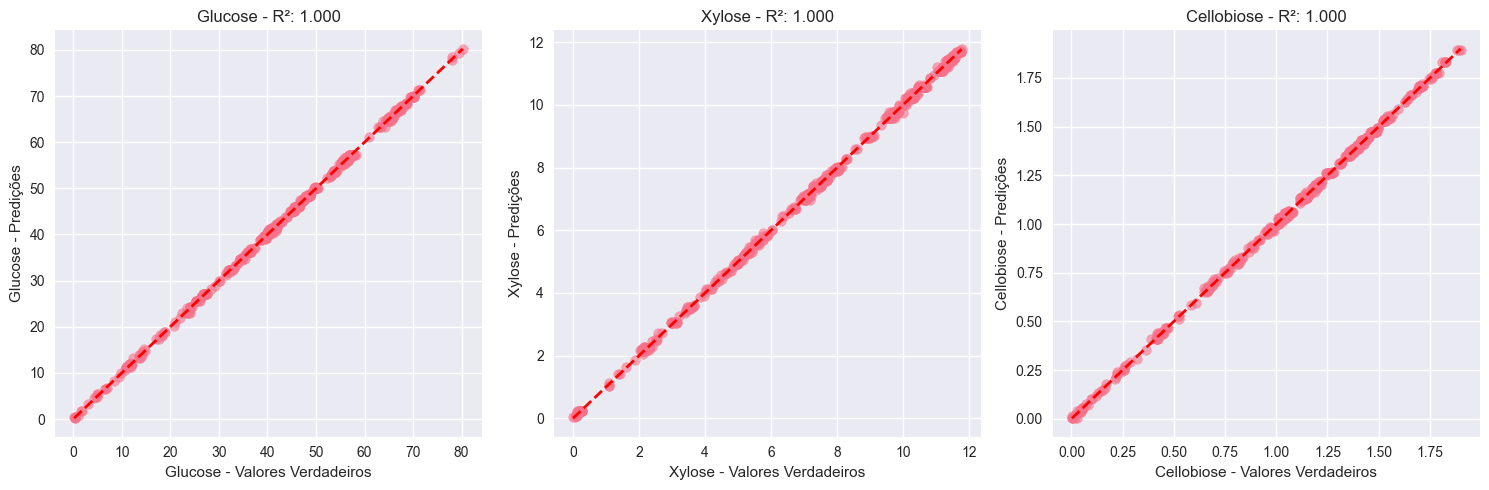

In [21]:
# Validação do modelo usando dados sintéticos
print("=== VALIDAÇÃO COM DADOS SINTÉTICOS ===")

# Testando o modelo nos dados sintéticos para verificar consistência
X_synthetic = synthetic_validation[input_features]
y_synthetic_true = synthetic_validation[output_targets]

# Padronizando
X_synthetic_scaled = scaler_X.transform(X_synthetic)
y_synthetic_true_scaled = scaler_y.transform(y_synthetic_true)

# Predições
y_synthetic_pred_scaled = optimized_model.predict(X_synthetic_scaled)
y_synthetic_pred = scaler_y.inverse_transform(y_synthetic_pred_scaled)

# Métricas de validação
synthetic_r2 = r2_score(y_synthetic_true, y_synthetic_pred, multioutput='raw_values')
synthetic_mse = mean_squared_error(y_synthetic_true, y_synthetic_pred, multioutput='raw_values')
synthetic_mae = mean_absolute_error(y_synthetic_true, y_synthetic_pred, multioutput='raw_values')

print("Métricas de validação com dados sintéticos:")
for i, target in enumerate(output_targets):
    print(f"{target}:")
    print(f"  R²: {synthetic_r2[i]:.4f}")
    print(f"  MSE: {synthetic_mse[i]:.4f}")
    print(f"  MAE: {synthetic_mae[i]:.4f}")

# Gráfico de predições vs valores reais para dados sintéticos
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, target in enumerate(output_targets):
    axes[i].scatter(y_synthetic_true.iloc[:, i], y_synthetic_pred[:, i], alpha=0.6)
    axes[i].plot([y_synthetic_true.iloc[:, i].min(), y_synthetic_true.iloc[:, i].max()], 
                 [y_synthetic_true.iloc[:, i].min(), y_synthetic_true.iloc[:, i].max()], 'r--', lw=2)
    axes[i].set_xlabel(f'{target} - Valores Verdadeiros')
    axes[i].set_ylabel(f'{target} - Predições')
    axes[i].set_title(f'{target} - R²: {synthetic_r2[i]:.3f}')

plt.tight_layout()
plt.show()

In [22]:
# Salvamento dos dados sintéticos e modelo
import joblib
from datetime import datetime

print("=== SALVAMENTO DOS RESULTADOS ===")

# Salvando dados sintéticos
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Salvando os conjuntos de dados sintéticos
synthetic_main.to_csv(f'synthetic_data_main_{timestamp}.csv', index=False)
synthetic_validation.to_csv(f'synthetic_data_validation_{timestamp}.csv', index=False)
synthetic_clean.to_csv(f'synthetic_data_clean_{timestamp}.csv', index=False)

print(f"Dados sintéticos salvos:")
print(f"- synthetic_data_main_{timestamp}.csv")
print(f"- synthetic_data_validation_{timestamp}.csv")
print(f"- synthetic_data_clean_{timestamp}.csv")

# Salvando o modelo otimizado
model_filename = f'optimized_model_{best_model_name.replace(" ", "_")}_{timestamp}.pkl'
joblib.dump(optimized_model, model_filename)
print(f"Modelo salvo: {model_filename}")

# Salvando os scalers
scaler_X_filename = f'scaler_X_{timestamp}.pkl'
scaler_y_filename = f'scaler_y_{timestamp}.pkl'
joblib.dump(scaler_X, scaler_X_filename)
joblib.dump(scaler_y, scaler_y_filename)
print(f"Scalers salvos: {scaler_X_filename}, {scaler_y_filename}")

# Salvando relatório de performance
performance_report = {
    'best_model': best_model_name,
    'test_r2_scores': dict(zip(output_targets, [float(x) for x in results[0]['test_r2']])),
    'test_mse_scores': dict(zip(output_targets, [float(x) for x in results[0]['test_mse']])),
    'synthetic_validation_r2': dict(zip(output_targets, [float(x) for x in synthetic_r2])),
    'synthetic_validation_mse': dict(zip(output_targets, [float(x) for x in synthetic_mse])),
    'timestamp': timestamp
}

import json
with open(f'performance_report_{timestamp}.json', 'w') as f:
    json.dump(performance_report, f, indent=2)

print(f"Relatório de performance salvo: performance_report_{timestamp}.json")

=== SALVAMENTO DOS RESULTADOS ===
Dados sintéticos salvos:
- synthetic_data_main_20250713_141739.csv
- synthetic_data_validation_20250713_141739.csv
- synthetic_data_clean_20250713_141739.csv
Modelo salvo: optimized_model_Random_Forest_20250713_141739.pkl
Scalers salvos: scaler_X_20250713_141739.pkl, scaler_y_20250713_141739.pkl
Relatório de performance salvo: performance_report_20250713_141739.json


In [23]:
# Função para geração futura de dados sintéticos
def generate_new_synthetic_data(model, scaler_X, scaler_y, n_samples=100, 
                                custom_ranges=None, add_noise=True, noise_level=0.05):
    """
    Função para gerar novos dados sintéticos usando modelo treinado
    
    Parâmetros:
    - model: modelo treinado
    - scaler_X, scaler_y: scalers para padronização
    - n_samples: número de amostras a gerar
    - custom_ranges: dict com ranges customizados para cada feature
    - add_noise: se deve adicionar ruído
    - noise_level: nível do ruído (0-1)
    """
    
    # Ranges padrão baseados nos dados originais
    default_ranges = {
        'Cellulose': (0.60, 0.70),
        'Hemicellulose': (0.07, 0.09),
        'Lignin': (0.20, 0.30),
        'Solids_Loading': (100, 250),
        'Enzyme_Loading': (0.05, 1.2),
        'Time': (0, 100)
    }
    
    # Usando ranges customizados se fornecidos
    ranges = custom_ranges if custom_ranges else default_ranges
    
    # Gerando inputs
    synthetic_inputs = {}
    for feature, (min_val, max_val) in ranges.items():
        if feature == 'Time':
            # Distribuição exponencial para tempo
            synthetic_inputs[feature] = np.random.exponential(scale=20, size=n_samples)
            synthetic_inputs[feature] = np.clip(synthetic_inputs[feature], min_val, max_val)
        else:
            synthetic_inputs[feature] = np.random.uniform(min_val, max_val, n_samples)
    
    synthetic_X = pd.DataFrame(synthetic_inputs)
    
    # Padronizando e fazendo predições
    synthetic_X_scaled = scaler_X.transform(synthetic_X)
    synthetic_y_scaled = model.predict(synthetic_X_scaled)
    synthetic_y = scaler_y.inverse_transform(synthetic_y_scaled)
    synthetic_y_df = pd.DataFrame(synthetic_y, columns=output_targets)
    
    # Adicionando ruído se solicitado
    if add_noise:
        for target in output_targets:
            noise = np.random.normal(0, noise_level * synthetic_y_df[target].std(), n_samples)
            synthetic_y_df[target] += noise
            synthetic_y_df[target] = np.maximum(synthetic_y_df[target], 0)
    
    return pd.concat([synthetic_X, synthetic_y_df], axis=1)

# Exemplo de uso da função
print("=== EXEMPLO DE GERAÇÃO DE NOVOS DADOS ===")

# Gerando dados com ranges customizados
custom_ranges = {
    'Cellulose': (0.65, 0.68),
    'Hemicellulose': (0.075, 0.085),
    'Lignin': (0.22, 0.28),
    'Solids_Loading': (120, 180),
    'Enzyme_Loading': (0.1, 0.5),
    'Time': (0, 50)
}

new_synthetic = generate_new_synthetic_data(
    optimized_model, scaler_X, scaler_y,
    n_samples=50, custom_ranges=custom_ranges
)

print("Novos dados sintéticos gerados:")
print(new_synthetic.head())
print(f"Shape: {new_synthetic.shape}")

print("\nEstatísticas dos novos dados:")
print(new_synthetic.describe())

=== EXEMPLO DE GERAÇÃO DE NOVOS DADOS ===
Novos dados sintéticos gerados:
   Cellulose  Hemicellulose    Lignin  Solids_Loading  Enzyme_Loading  \
0   0.672748       0.082965  0.221895      172.021890        0.166817   
1   0.650738       0.079815  0.276173      154.720525        0.167048   
2   0.650664       0.076173  0.223118      146.316925        0.114669   
3   0.659708       0.076252  0.252478      163.515460        0.394561   
4   0.664659       0.081856  0.262544      149.200136        0.365522   

        Time    Glucose    Xylose  Cellobiose  
0  13.750252  34.331249  3.994922    0.974731  
1  19.238697  46.943760  4.846198    1.311064  
2  40.636658  41.288251  6.927674    0.889513  
3  16.907782  45.268494  7.391793    1.100106  
4   0.617166  12.229307  2.110451    0.137739  
Shape: (50, 9)

Estatísticas dos novos dados:
       Cellulose  Hemicellulose     Lignin  Solids_Loading  Enzyme_Loading  \
count  50.000000      50.000000  50.000000       50.000000       50.000000 

# Resumo e Conclusões

## Resultados Obtidos

### Modelos Testados
Foram testados 9 diferentes algoritmos de regressão do Scikit-learn:
1. Regressão Linear
2. Regressão Ridge
3. Regressão Lasso
4. Elastic Net
5. Random Forest
6. Gradient Boosting
7. Support Vector Regression (SVR)
8. K-Nearest Neighbors
9. Decision Tree

### Metodologia
1. **Pré-processamento**: Padronização das variáveis usando StandardScaler
2. **Divisão dos dados**: 80% treino, 20% teste
3. **Avaliação**: Métricas R², MSE e MAE para cada variável de saída
4. **Otimização**: GridSearchCV para o melhor modelo
5. **Geração sintética**: Criação de dados sintéticos com distribuições realísticas

### Variáveis Analisadas
- **Entradas**: Celulose, Hemicelulose, Lignina, Solids Loading, Enzyme Loading, Tempo
- **Saídas**: Concentração de Glicose, Xilose e Celobiose

### Aplicações dos Dados Sintéticos
1. **Aumento do dataset**: Expandir o conjunto de dados para treinamento
2. **Simulação de cenários**: Testar diferentes condições experimentais
3. **Validação de modelos**: Verificar robustez dos algoritmos
4. **Planejamento experimental**: Identificar condições ótimas

### Próximos Passos
1. Validação experimental dos dados sintéticos
2. Incorporação de mais variáveis do processo
3. Desenvolvimento de modelos mais complexos (Deep Learning)
4. Otimização multi-objetivo das condições de processo